In [4]:
import pandas as pd
import numpy as np
import requests, time
from pathlib import Path
from datetime import datetime

from tensorflow.keras.models import model_from_json, load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from functions import *

%matplotlib inline

In [5]:
MSFT_df = pd.read_csv(
    Path('../data/stocks_history.csv'),
    index_col='Unnamed: 0',
    infer_datetime_format=True,
    parse_dates=True
)
dropped_columns = [
    'MSFT_open',
    'MSFT_high',
    'MSFT_low',
    'AMD_close',
    'AMD_open',
    'AMD_high',
    'AMD_low',
    'TSLA_close',
    'TSLA_open',
    'TSLA_high',
    'TSLA_low',
    'JNJ_close',
    'JNJ_open',
    'JNJ_high',
    'JNJ_low',
    'REGN_close',
    'REGN_open',
    'REGN_high',
    'REGN_low',
    'GILD_close',
    'GILD_open',
    'GILD_high',
    'GILD_low'
]
MSFT_df.drop(columns=dropped_columns, inplace=True)
MSFT_df.dropna(inplace=True)
MSFT_df.columns = ['Close']
MSFT_df.head()

X_MSFT, y_MSFT = window_data(
        df=MSFT_df,
        window = 50,
        feature_col_number=0,
        target_col_number=0
    )
    
scaler = MinMaxScaler()
X = scaler.fit(X_MSFT)
X = scaler.transform(X_MSFT)
y = scaler.fit(y_MSFT)
y = scaler.transform(y_MSFT)

X = X.reshape((X.shape[0], X.shape[1], 1))

# Load json and create model
model_path = './models/JNJ_close_1lstm_model.h5'

# load model
model = load_model(model_path)

# predict prices
predicted = model.predict(X)

# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y.reshape(-1, 1))

stocks = pd.DataFrame({
"Real": real_prices.ravel(),
"Predicted": predicted_prices.ravel()
})

In [18]:
pred_list = []
n_input = 50
n_features = 1

MSFT = scaler.transform(MSFT_df)

batch = MSFT[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[pred_list[i]]], axis=1)
    
df_predict = pd.DataFrame(
    scaler.inverse_transform(pred_list),
    index=MSFT_df[-n_input:].index,
    columns=['Predictions']
)

df_test = pd.concat([MSFT_df,df_predict], axis=1)

from pandas.tseries.offsets import DateOffset
add_dates = [MSFT_df.index[-1] + DateOffset(days=x) for x in range(0,51)]
future_dates = pd.DataFrame(index=add_dates[1:],columns=MSFT_df.columns)

df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index,columns=['Prediction'])

df_proj = pd.concat([MSFT_df,df_predict], axis=1)

In [19]:
df_proj

,Close,Prediction
2010-06-29,23.3100,NaN
2010-06-30,23.0100,NaN
2010-07-01,23.1600,NaN
2010-07-02,23.2700,NaN
2010-07-06,23.8200,NaN
2010-07-07,24.3000,NaN
2010-07-08,24.4095,NaN
2010-07-09,24.2700,NaN
2010-07-12,24.8300,NaN
2010-07-13,25.1300,NaN


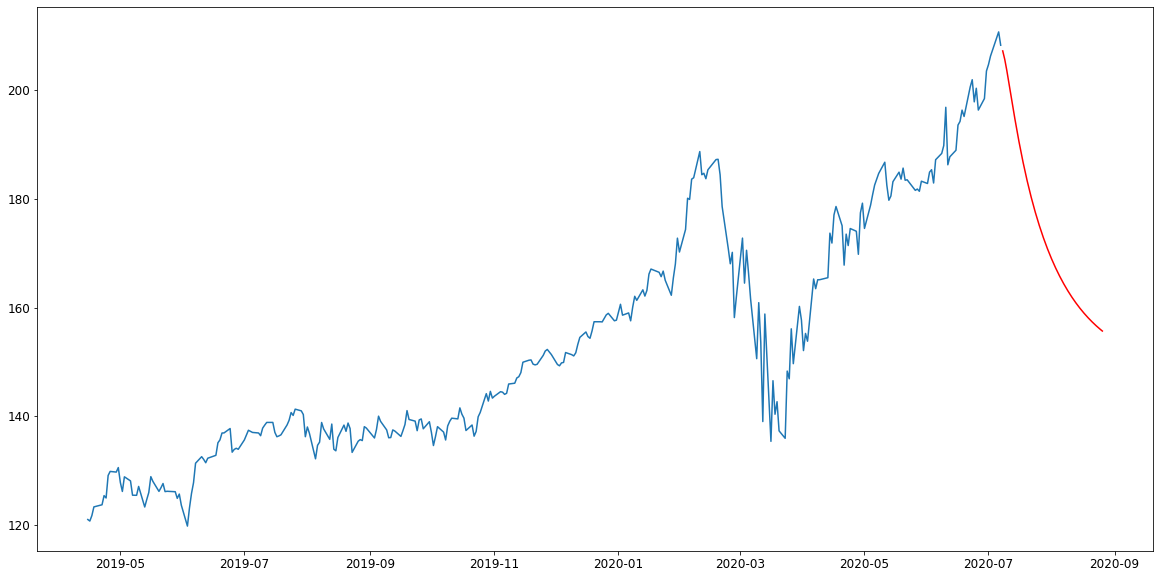

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(df_proj.iloc[-360:,].index, df_proj['Close'].iloc[-360:])
plt.plot(df_proj.iloc[-360:,].index, df_proj['Prediction'].iloc[-360:], color='r')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()